In [1]:
import fire
import numpy as np
from registration import *
from starfish.spots import DecodeSpots
from starfish.types import Levels, Axes, TraceBuildingStrategies
from starfish.core.imagestack.imagestack import ImageStack
from starfish.spots import FindSpots, DecodeSpots
from starfish.core.types import SpotFindingResults
from starfish.core.intensity_table.decoded_intensity_table import DecodedIntensityTable
from starfish import Experiment, FieldOfView
from starfish.image import Filter
from starfish.core.spots.DecodeSpots.trace_builders import build_spot_traces_exact_match
from starfish.core.intensity_table.intensity_table_coordinates import \
        transfer_physical_coords_to_intensity_table
import matplotlib.pyplot as plt

In [2]:
json = "/scratch/vakili/work-alvaro2/e5/bc2600b7b1ebb8e510ccb0388b18bd/experiment.json"
exp = Experiment.from_json(json)
primary = exp['fov_102'].get_image(FieldOfView.PRIMARY_IMAGES)
reference = exp['fov_102'].get_image('anchor_dots')

In [3]:
primary.sel({Axes.ROUND:1, Axes.CH:0}).xarray[0][0][0].shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.75it/s]


(1900, 1900)

In [40]:
img = primary.sel({Axes.ROUND:6, Axes.CH:0}).xarray[0][0][0]

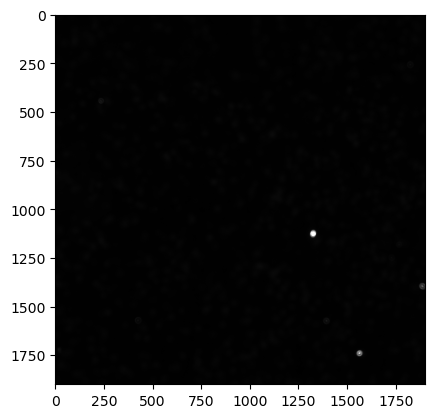

In [41]:
plt.imshow(img, cmap='gray', vmax=np.max(img)/2)

In [7]:
primary

<starfish.ImageStack (r: 9, c: 2, z: 1, y: 1900, x: 1900)>

In [11]:
bd = FindSpots.BlobDetector(
            min_sigma=1,
            max_sigma=3,
            num_sigma=30,
            threshold=.02,
            is_volume=False,
            measurement_type='mean')
# dots_max = reference_stack.reduce((Axes.ROUND, Axes.ZPLANE),
#                                    func='max')
# Locate spots in reference image
spots = bd.run(image_stack=primary)


IndexError: index 3 is out of bounds for axis 1 with size 3

In [8]:
tlmpf = starfish.spots.FindSpots.TrackpyLocalMaxPeakFinder(
    spot_diameter=5,
    min_mass=1,
    max_size=2,
    separation=3,
    noise_size=0.65,
    preprocess=False,
    percentile=10,
    verbose=True,
    is_volume=True,
)
spots = tlmpf.run(primary)

KeyboardInterrupt: 

In [104]:
d = DecodeSpots.SimpleLookupDecoder(codebook=exp.codebook,)

In [105]:
dd = d.run(spots=spots)

ValueError: different number of dimensions on data and dims: 1 vs 0

In [101]:
(dd.to_features_dataframe().passes_thresholds == False).all()

True

In [102]:
dd.to_features_dataframe()

,intensity,radius,spot_id,x,x_max,x_min,y,y_max,y_min,z,z_max,z_min,features,xc,yc,zc,target,distance,passes_thresholds
0,0.014878,3.0,0,1632,1635,1630,1899,1900,1897,0,1,0,0,9232.859400,15200.000000,0.00005,nan,0.0,False
1,0.004676,2.0,1,1277,1279,1276,1885,1887,1884,0,1,0,1,8877.672459,15185.992628,0.00005,nan,0.0,False
2,0.006134,3.0,2,1269,1272,1267,1884,1887,1882,0,1,0,2,8869.668246,15184.992101,0.00005,nan,0.0,False
3,0.004915,2.0,3,1273,1275,1272,1878,1880,1877,0,1,0,3,8873.670353,15178.988942,0.00005,nan,0.0,False
4,0.004312,3.0,4,1265,1268,1263,1875,1878,1873,0,1,0,4,8865.666140,15175.987362,0.00005,nan,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577,0.146254,2.0,3577,222,224,221,11,13,10,0,1,0,3577,7822.116904,13311.005793,0.00005,nan,0.0,False
3578,0.391448,2.0,3578,202,204,201,10,12,9,0,1,0,3578,7802.106372,13310.005266,0.00005,nan,0.0,False
3579,0.207193,3.0,3579,196,199,194,10,13,8,0,1,0,3579,7796.103212,13310.005266,0.00005,nan,0.0,False
3580,0.238228,3.0,3580,198,201,196,7,10,5,0,1,0,3580,7798.104265,13307.003686,0.00005,nan,0.0,False


In [4]:
# Load smFISH data and find spots
import starfish.data
from starfish import FieldOfView
from starfish.types import Levels
from starfish.image import Filter
experiment = starfish.data.allen_smFISH(use_test_data=True)
image = experiment["fov_001"].get_image(FieldOfView.PRIMARY_IMAGES)

bandpass = Filter.Bandpass(lshort=.5, llong=7, threshold=0.0)
glp = Filter.GaussianLowPass(
    sigma=(1, 0, 0),
    is_volume=True
)
clip1 = Filter.Clip(p_min=50, p_max=100, level_method=Levels.SCALE_BY_CHUNK)
clip2 = Filter.Clip(p_min=99, p_max=100, is_volume=True, level_method=Levels.SCALE_BY_CHUNK)
tlmpf = starfish.spots.FindSpots.TrackpyLocalMaxPeakFinder(
    spot_diameter=5,
    min_mass=0.02,
    max_size=2,
    separation=7,
    noise_size=0.65,
    preprocess=False,
    percentile=10,
    verbose=True,
    is_volume=True,
)
clip1.run(image, in_place=True)
bandpass.run(image, in_place=True)
glp.run(image, in_place=True)
clip2.run(image, in_place=True)
print(image)
spots = tlmpf.run(image)

# Decode spots with SimpleLookupDecoder
from starfish.spots import DecodeSpots
decoder = DecodeSpots.SimpleLookupDecoder(codebook=experiment.codebook)
decoded_intensities = decoder.run(spots=spots)

is_volume is a deprecated parameter.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.41it/s]


<starfish.ImageStack (r: 1, c: 3, z: 34, y: 2048, x: 2048)>
